# WeatherPy: Weather Analysis Based on Latitude (6/6/2018)

Based on this analysis, latitude can only be used to predict temperature and demonstrates no relationship with a city's humidity, cloudiness, or wind speed.

To perform this analysis:
- To ensure a good sample of data, I generated 1,500 random, unique cities around the world using a combination of randomized latitude/longitude pairs and Citipy (to ensure I returned an actual city, not just a location on a map).
- To ensure that I didn't have false positives when determining if a city was a duplicate (for example, Bagdhad, Arizona and Baghdad, Iraq are two very different cities), I combined the city and county to create a hash of sorts.
- I pulled weather data that corresponded to those cities from OpenWeatherMap on 6/6/2018 at approximately 10:00 PM PST.

In [21]:
# -----------------------------------------------------------------------------------
# Step 1: Import the modules 
# -----------------------------------------------------------------------------------
import seaborn as sns
import json
import datetime as dt
import matplotlib.pyplot as plt
import requests as req
import pandas as pd
import random as rd
from citipy import citipy
from localenv import api_key
from aux import displayProcessingCity, displayFailedCity, continentFromCountry

## City Data

In [7]:
# -----------------------------------------------------------------------------------
# Step 2: Store all our basic API data. I'd use params, but I couldn't get it to work
# with the unique structure of some of these parameters
# -----------------------------------------------------------------------------------

tempUnits = 'Imperial'
openWeatherURL = "http://api.openweathermap.org/data/2.5/weather?"

In [8]:
# -----------------------------------------------------------------------------------
# Step 3: Create a list of non-duplicate cities
# -----------------------------------------------------------------------------------
# create a list that we'll store all our data in
weatherData_list = []
city_list = []

# create dupe checking set
cityDupeChecker = set()

# create counter
i = 0

# create a list of 1500 possible cities (so even if a query fails still have good sample)
while len(cityDupeChecker) < 1500:
    
    # set random lat and long
    latitude = rd.uniform(-90.0,90.0)
    longitude = rd.uniform(-180.0,180.0)
    
    # get city
    city = citipy.nearest_city(latitude,longitude).city_name
    country = citipy.nearest_city(latitude,longitude).country_code
    city_country_pair = f"{city}_{country}"
    
    if city_country_pair not in cityDupeChecker:
        cityDupeChecker.add(city_country_pair)
        
        # try to pull in a random value and add to dupe checker
        city_list.append([city, country])

# -----------------------------------------------------------------------------------
# Step 4: Pull city data from openweatherapi
# -----------------------------------------------------------------------------------
for i in range(len(city_list)):
    
    # get current city and country
    city = city_list[i][0]
    country= city_list[i][1]
        
    # try searching by city + country code
    try:
        response = req.get(f"{openWeatherURL}q={city},{country}&units={tempUnits}&APPID={api_key}").json()
        
        # add information from response to list
        weatherData_list.append({'cityID':response['id'],
                                 'city': response['name'],
                                 'country': country.upper(),
                                 'continent': continentFromCountry(country.upper()),
                                 'latitude':response['coord']['lat'],
                                 'longitude':response['coord']['lon'],
                                 'humidity':response['main']['humidity'],
                                 'temperature':response['main']['temp'],
                                 'windSpeed':response['wind']['speed'],
                                 'cloudiness':response['clouds']['all'] })
        
        #show city
        #displayProcessingCity(i,response)
    except:    
        try:
            response = req.get(f"{openWeatherURL}q={city}&units={tempUnits}&APPID={api_key}").json()
            
            # add information from response to list
            weatherData_list.append({'cityID':response['id'],
                                     'city': response['name'],
                                     'country': response['main']['sys']['country'].upper(),
                                     'continent': continentFromCountry(response['main']['sys']['country'].upper()),
                                     'latitude': response['coord']['lat'],
                                     'longitude': response['coord']['lon'],
                                     'humidity':response['main']['humidity'],
                                     'temperature':response['main']['temp'],
                                     'windSpeed':response['wind']['speed'],
                                     'cloudiness':response['clouds']['all']})
                                    
            #show city
            #displayProcessingCity(i,response)
        except:
            #displayFailedCity(i, city, country)
            pass

In [9]:
# -----------------------------------------------------------------------------------
# Step 4: Create a pretty dataframe that we can reference because visual aids are
# the actual best thing ever and export a CSV we can hang onto
# -----------------------------------------------------------------------------------
cleanedWeather_df = pd.DataFrame(weatherData_list)

# rearrange columns sensibly
cleanedWeather_df = cleanedWeather_df[['cityID', 'city', 'country', 'continent',
                                       'latitude', 'longitude',
                                       'temperature', 
                                       'humidity', 
                                       'windSpeed',
                                       'cloudiness']].sort_index(ascending=True)

# export the csv
cleanedWeather_df.to_csv("csv/WeatherData.csv")

# eyeball our data
cleanedWeather_df.head()

,cityID,city,country,continent,latitude,longitude,temperature,humidity,windSpeed,cloudiness
0,4032243,Vaini,TO,Oceania,-21.20,-175.20,78.80,94,4.70,75
1,3863379,Mar del Plata,AR,South America,-46.43,-67.52,23.48,100,3.40,0
2,587207,Artyom,AZ,Asia,40.47,50.33,71.60,78,18.34,75
3,370481,Marawi,SD,Africa,18.48,31.82,88.01,24,6.42,0
4,5175079,Van Wert,US,North America,40.86,-84.58,63.03,48,10.29,90


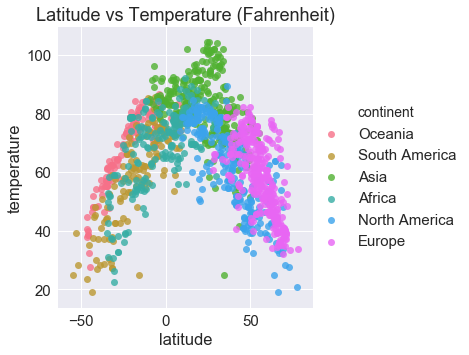

In [16]:
# -----------------------------------------------------------------------------------
# Step 5: Generate charts.
#  1) Temperature (F) vs. Latitude
#  2) Humidity (%) vs. Latitude
#  3) Cloudiness (%) vs. Latitude
#  4) Wind Speed (mph) vs. Latitude
# -----------------------------------------------------------------------------------
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Chart 1: Temperature vs Latitude
latVsTemp_plot = sns.lmplot(x='latitude', 
                            y='temperature', 
                            data=cleanedWeather_df,
                            hue='continent',
                            fit_reg=False, 
                            palette='husl')
plt.title("Latitude vs Temperature (Fahrenheit)")
plt.savefig("images/latXtemp.png")
plt.show()

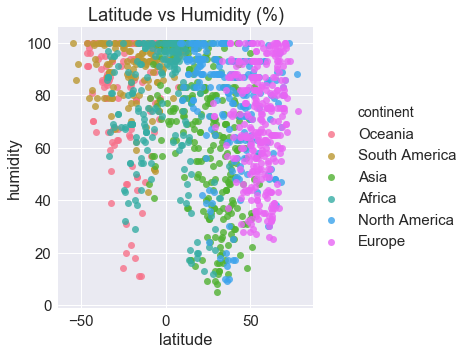

In [18]:
# Chart 2: humidity vs Latitude
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

latVsTemp_plot = sns.lmplot(x='latitude', 
                            y='humidity', 
                            data=cleanedWeather_df,
                            hue='continent',
                            palette='husl',
                            fit_reg=False)
plt.title("Latitude vs Humidity (%)")
plt.savefig("images/latXhumid.png")
plt.show()

There is no relationship between latitude and humidity.

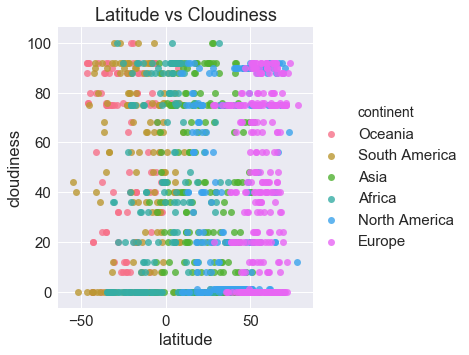

In [19]:
# Chart 3: cloudiness vs Latitude
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

latVsTemp_plot = sns.lmplot(x='latitude', y='cloudiness', 
                            data=cleanedWeather_df,
                            hue='continent',
                            palette='husl',
                            fit_reg=False)
plt.title("Latitude vs Cloudiness")
plt.savefig("images/latXcloud.png")
plt.show()

There is no relationship between latitude and cloudiness.

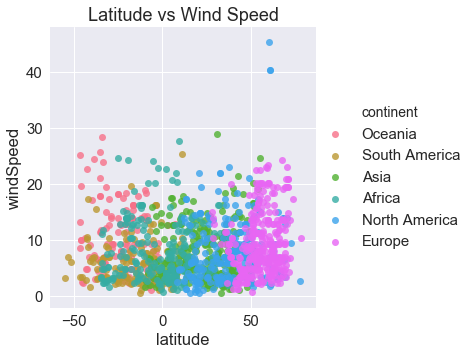

In [20]:
# Chart 4: wind speed vs Latitude
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

latVsTemp_plot = sns.lmplot(x='latitude', y='windSpeed', 
                            data=cleanedWeather_df,
                            hue='continent',
                            palette='husl',
                            fit_reg=False)
plt.title("Latitude vs Wind Speed")
plt.savefig("images/latXwind.png")
plt.show()

There is no apparent relationship between latitude and wind speed.

In [24]:
print(dt.datetime.now().strftime(%y))

SyntaxError: invalid syntax (<ipython-input-24-6f973f3df83a>, line 1)